<a href="https://colab.research.google.com/github/BachirKharfi/Portfolioproject/blob/main/Analyzing_LA_Crime_Data_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Leaning Stage:

After preparing and cleaning the dataset, it is time to outline a value for the model to predict. I've decided to predict "Crime Severity" column of the dataset, which i created earlier from the other columns. But instead of creating a multiclass prediction model to predict between the 8 values in that column ['Petty', 'GrandTheft', 'Unknown' ...]. I will be using a binary classification model to predict whether a crime is a felony or not.
This mainly due to 3 reasons:

- Chenical and resources considerations.
- Felony crimes quite common in the dataset, accounting for nearly 60% of the crime severit classes.
- Felony crimes are more likely to be reported and investigated and considered more serious in general.

#### Importing the necessary libraries.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing the dataset

In [3]:
ml_df = pd.read_csv('/content/drive/MyDrive/Analyzing Crime Data/ml_df_new.csv')
ml_df.head()

,Unnamed: 0,Ocurred_Time,Hour,diff_occ_rptd (hours),Area_Name,Cleaned_Crime_Description,Crime_Severity,Victim_Age,Victim_Sex,Victim_Ethnicity,Cleaned_Premises_Description,Cleaned_Weapon_Description,Status_Description,Crime_Code_1,Latitude,Longitude
0,0,11:20,11,0 days,77th Street,Robbery,Felony,65,F,H,Outdoor,Knife,Invest Cont,210.0,33.9737,-118.2827
1,1,03:15,3,0 days,Mission,Vandalism,Felony,51,M,O,Food Establishment,Unknown,Invest Cont,740.0,34.2467,-118.4479
2,2,15:45,15,0 days,West LA,Auto-Vehicle Theft,Petty,38,F,W,Parking,Unknown,Invest Cont,420.0,34.0463,-118.4171
3,3,17:30,17,8 days,Van Nuys,Violating restraining order,Unknown,64,M,H,Residential,Unknown,Adult Other,901.0,34.1668,-118.4445
4,4,15:00,15,5 days,West LA,Bunco,Grand Theft,73,F,W,Residential,Unknown,Invest Cont,662.0,34.0889,-118.5325


#### Scaling the numeric values in the dataset.

The reason i went with MinMaxScaler instead of other more commonly used methods of scaling, is because the dataset will grow quite large and i plan on using SelectKbest with Chi2 to reduce the size of the dataset.

In [4]:
scaler = MinMaxScaler()
age_scaled = scaler.fit_transform(ml_df['Victim_Age'].values.reshape(-1, 1))
age_scaled = pd.DataFrame(age_scaled, columns=['Scaled_Victim_Age'])

In [5]:
lat_scaled = scaler.fit_transform(ml_df['Latitude'].values.reshape(-1, 1))
lat_scaled = pd.DataFrame(lat_scaled, columns=['Scaled_Latitude'])

In [6]:
lon_scaled = scaler.fit_transform(ml_df['Longitude'].values.reshape(-1, 1))
lon_scaled = pd.DataFrame(lon_scaled, columns=['Scaled_Longitude'])

In [7]:
ml_df = pd.concat([ml_df, age_scaled, lat_scaled, lon_scaled], axis=1)

#### Cleaning the dataset

In [8]:
ml_df.Cleaned_Weapon_Description = ml_df.Cleaned_Weapon_Description.replace('Vehicle', 'Vehicle_Wea')

In [9]:
ml_df['diff_occ_rptd (hours)']

0         0 days
1         0 days
2         0 days
3         8 days
4         5 days
           ...  
295506    0 days
295507    8 days
295508    1 days
295509    0 days
295510    5 days
Name: diff_occ_rptd (hours), Length: 295511, dtype: object

In [10]:
ml_df.rename(columns={'diff_occ_rptd (hours)': 'diff_occ_rptd (days)'}, inplace=True)

In [11]:
ml_df['diff_occ_rptd (days)'] = ml_df['diff_occ_rptd (days)'].str.strip('days')

In [12]:
ml_df['diff_occ_rptd (days)']  = ml_df['diff_occ_rptd (days)'].astype(int)

#### Getting rid of useless or redundent columns.

In [14]:
ml_df = ml_df.drop(['Victim_Age', 'Ocurred_Time', 'Unnamed: 0', 'Crime_Code_1', 'Latitude', 'Longitude'], axis=1)

In [15]:
ml_df.head()

,Hour,diff_occ_rptd (days),Area_Name,Cleaned_Crime_Description,Crime_Severity,Victim_Sex,Victim_Ethnicity,Cleaned_Premises_Description,Cleaned_Weapon_Description,Status_Description,Scaled_Victim_Age,Scaled_Latitude,Scaled_Longitude
0,11,0,77th Street,Robbery,Felony,F,H,Outdoor,Knife,Invest Cont,0.649485,0.425705,0.751464
1,3,0,Mission,Vandalism,Felony,M,O,Food Establishment,Unknown,Invest Cont,0.505155,0.860487,0.428934
2,15,0,West LA,Auto-Vehicle Theft,Petty,F,W,Parking,Unknown,Invest Cont,0.371134,0.541328,0.489067
3,17,8,Van Nuys,Violating restraining order,Unknown,M,H,Residential,Unknown,Adult Other,0.639175,0.733238,0.435572
4,15,5,West LA,Bunco,Grand Theft,F,W,Residential,Unknown,Invest Cont,0.731959,0.609173,0.263764


In [16]:
ml_df.shape

(295511, 13)

#### Encoding Categorical Variables.

In [17]:
crime_desc_enc = pd.get_dummies(ml_df['Cleaned_Crime_Description'], drop_first=True)

In [18]:
vict_sex_enc = pd.get_dummies(ml_df['Victim_Sex'], drop_first=True)

In [19]:
vict_eth_enc = pd.get_dummies(ml_df['Victim_Ethnicity'], drop_first=True)

In [20]:
prem_desc_enc = pd.get_dummies(ml_df['Cleaned_Premises_Description'], drop_first=True)

In [21]:
wea_desc_enc = pd.get_dummies(ml_df["Cleaned_Weapon_Description"], drop_first=True)

In [22]:
status_desc_enc = pd.get_dummies(ml_df["Status_Description"], drop_first=True)

In [23]:
hour_enc = pd.get_dummies(ml_df['Hour'], drop_first=True)

In [24]:
area_enc = pd.get_dummies(ml_df['Area_Name'], drop_first=True)

In [25]:
cols = ml_df[["diff_occ_rptd (days)", "Crime_Severity", "Scaled_Victim_Age", "Scaled_Latitude", "Scaled_Longitude"]]

In [26]:
#ml_df["Crime_Code_1"] = ml_df["Crime_Code_1"].astype(int)

In [27]:
ml_df = pd.concat([cols, crime_desc_enc, hour_enc, area_enc, vict_sex_enc, vict_eth_enc, prem_desc_enc, wea_desc_enc, status_desc_enc], axis=1)

In [28]:
ml_df.head()

,diff_occ_rptd (days),Crime_Severity,Scaled_Victim_Age,Scaled_Latitude,Scaled_Longitude,Arson,Assault,Auto-Vehicle Burglary,Auto-Vehicle Theft,Battery,Brandishing a weapon,Bunco,Burglary,Contempt of Court,Contributing,Counterfitting,Criminal Threats,Defrauding an Innkeeper,Dishonest Employee,Disturbing the peace,Domestic Violence,Driving without owner conset,Embezzlement,Extortion,False Imprisonment,False report,Firearm Discharge,Forgery,Fraud,Hacking,Homicide,Human Trafficking,Identity Theft,Illegal Dumping,Kidnapping,Miscellaneous Crime,Prostitution,Reckless Driving,Resisting Arrest,Robbery,Sexual Assault,Shooting at an inhabited Dwelling,Shooting at an occupied Vehicle,Stalking,Theft,Throwing Objects at moving Vehicles,Trespassing,Vandalism,Violating Court Order,Violating restraining order,traffic infraction,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Central,Devonshire,Foothill,Harbor,Hollenbeck,Hollywood,Mission,N Hollywood,Newton,Northeast,Olympic,Pacific,Rampart,Southeast,Southwest,Topanga,Van Nuys,West LA,West Valley,Wilshire,M,B,C,D,F,G,H,I,J,K,L,O,P,S,U,V,W,X,Z,Automotive,Beauty,Business,Childcare,Construction,Cyberspace,Delivery Service,Educational,Entertainment,Financial Institution,Food Establishment,Gas Station,Government,Healthcare,Infrastructure,Lodging,Mail Services,Manufacturing,Marina,Office,Online,Other,Outdoor,Parking,Public Restroom,Public Services,Public Transportation,Recreation,Recycling,Religious,Residential,Retail,Storage,Street,Telecommunication,Transportation,Vehicle,Blunt Instrument,Bottle,Chemical,Chemical Spray,Electric Shock,Explosive,Fire,Firearm,Firearm (Toy),Knife,Physical Force,Sharp Object,Strangulation,Substance,Threat,Thrown Object,Unknown,Vehicle_Wea,Adult Other,Invest Cont,Juv Arrest,Juv Other
0,0,Felony,0.649485,0.425705,0.751464,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,Felony,0.505155,0.860487,0.428934,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,Petty,0.371134,0.541328,0.489067,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,8,Unknown,0.639175,0.733238,0.435572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,5,Grand Theft,0.731959,0.609173,0.263764,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [29]:
# Datset has grown quite large with 172 columns
ml_df.shape

(295511, 172)

#### Encoding the target variable.

In [30]:
ml_df["Crime_Sev_Enc"] = ml_df["Crime_Severity"].apply(lambda x: 1 if x == 'Felony' else 0)

In [31]:
ml_df["Crime_Sev_Enc"].value_counts()

0    175201
1    120310
Name: Crime_Sev_Enc, dtype: int64

In [32]:
ml_df = ml_df.drop("Crime_Severity", axis=1)

This Dataset is too large for my machine to handle, so I will be using the following code to reduce the size of the dataset. Since the target variable is a categorical variable, I will first sample the data using stratified sampling technique.

In [33]:
ml_df.Crime_Sev_Enc.value_counts(normalize=True) * 100

0    59.287472
1    40.712528
Name: Crime_Sev_Enc, dtype: float64

In [34]:
ml_df_sam = ml_df.groupby(["Crime_Sev_Enc"]).sample(frac=0.1, random_state=42)

The distribution of the target variable in the reduced dataset is shown below. It matches the distribution of the original dataset.

In [35]:
ml_df_sam.Crime_Sev_Enc.value_counts(normalize=True) * 100

0    59.287334
1    40.712666
Name: Crime_Sev_Enc, dtype: float64

In [36]:
#ml_df.to_csv('/content/drive/MyDrive/Analyzing Crime Data/finalized_ml_df.csv')

## Splitting the dataset and Training the model.

In this stage i will be splitting the dataset into training and testing sets to avoid overfitting, then i will train the model on two of the most common classification algorithms: Logistic Regression and XGBoostClassifier.
First i will simple versions of those models then i will use finer tuned versions of them.

### Splitting the dataset

In [37]:
X = ml_df_sam.drop('Crime_Sev_Enc', axis=1)
y = ml_df_sam['Crime_Sev_Enc']

In [38]:
col_names = X.columns

In [39]:
X.columns = X.columns.astype(str)
#y.columns = y.columns.astype(str)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### **Addressing Class Imbalance:**

In [66]:
print(ml_df_sam['Crime_Sev_Enc'].value_counts(normalize=True) * 100)

0    59.287334
1    40.712666
Name: Crime_Sev_Enc, dtype: float64


Now i will correct for class imbalance using SMOTE.

SMOTE stands for "Synthetic Minority Over-sampling Technique." It is a technique used in machine learning and data preprocessing to address class imbalance in a dataset, particularly in classification problems.

In many real-world datasets, you may encounter situations where one class (the majority class) significantly outnumbers another class (the minority class). Class imbalance can lead to biased model training, where the model performs well on the majority class but poorly on the minority class.

SMOTE helps mitigate this problem by oversampling the minority class. It works by generating synthetic examples for the minority class based on the existing data. Here's how SMOTE typically works:

1. For each example in the minority class, SMOTE selects its k nearest neighbors from the minority class. The value of k is a user-defined parameter.

2. SMOTE then generates synthetic examples by interpolating between the selected example and its neighbors. It creates new examples along the line segments connecting the original example to its neighbors.

3. These synthetic examples are added to the minority class, effectively increasing the number of minority class samples in the dataset.

By oversampling the minority class in this way, SMOTE helps balance the class distribution, making it more even and reducing the risk of model bias towards the majority class. This, in turn, can lead to improved model performance, especially in scenarios where the minority class is of particular interest or importance.

SMOTE is a valuable tool for addressing class imbalance issues and is widely used in machine learning when dealing with imbalanced datasets.

In [46]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Logistic Regression with SMOTE:

In [47]:
# Instantiate a LogisticRegression model
model_log_reg = LogisticRegression(solver='lbfgs', max_iter=10000)


model_log_reg.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = model_log_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate a classification report
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9534765691084419
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3504
           1       0.91      0.99      0.95      2407

    accuracy                           0.95      5911
   macro avg       0.95      0.96      0.95      5911
weighted avg       0.96      0.95      0.95      5911



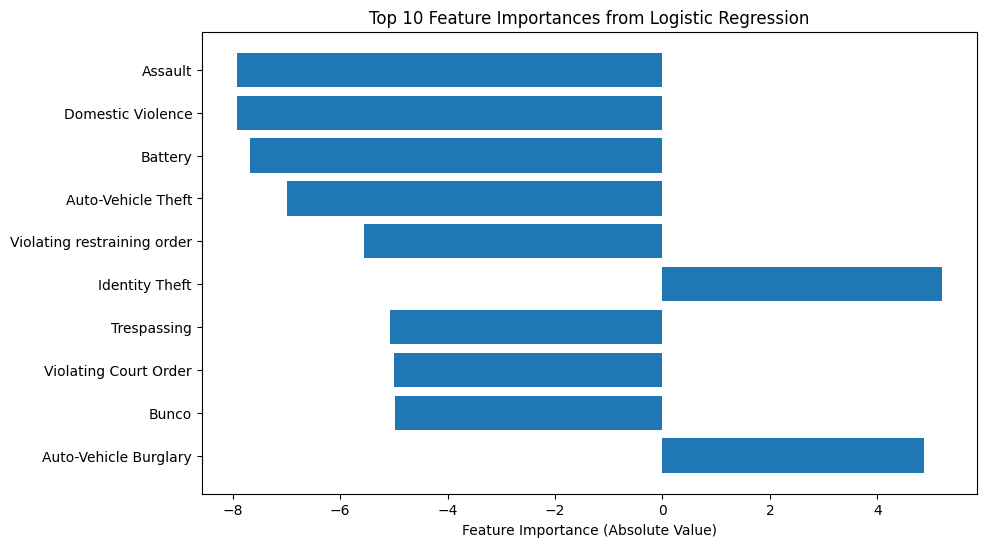

In [48]:
# Get feature importances from the model (coefficients in this case)
feature_importance = model_log_reg.coef_[0]

# Get the names of your feature columns
feature_names = X_train.columns

# Sort feature importances by absolute value in descending order
sorted_idx = np.argsort(abs(feature_importance))[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot the top N most important features
top_n = 10  # Adjust to the number of features you want to plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), sorted_feature_importance[:top_n], align='center')
plt.yticks(np.arange(top_n), sorted_feature_names[:top_n])
plt.xlabel('Feature Importance (Absolute Value)')
plt.title('Top {} Feature Importances from Logistic Regression'.format(top_n))
plt.gca().invert_yaxis()
plt.show()

### XGBoostClassifier with SMOTE:

In [49]:
# Create an XGBoost classifier model
xgb = XGBClassifier()

# Train the model on the training data
xgb.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = xgb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate a classification report
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9527998646591102
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3504
           1       0.91      0.98      0.94      2407

    accuracy                           0.95      5911
   macro avg       0.95      0.96      0.95      5911
weighted avg       0.96      0.95      0.95      5911



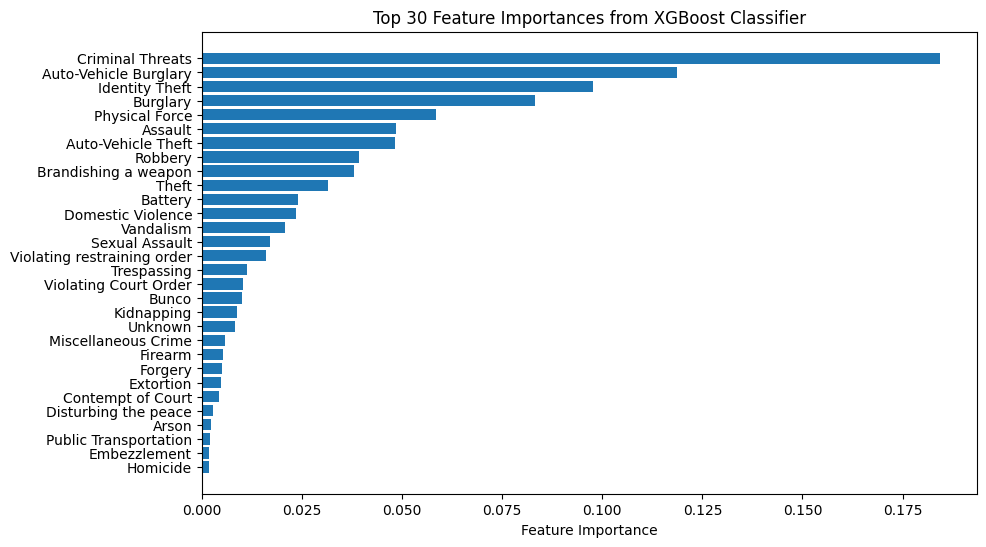

In [50]:
# Get feature importances from the model
feature_importance = xgb.feature_importances_

# Get the names of your feature columns
feature_names = X_train.columns  # Replace with the actual names of your features

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot the top N most important features
top_n = 30  # Adjust to the number of features you want to plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), sorted_feature_importance[:top_n], align='center')
plt.yticks(np.arange(top_n), sorted_feature_names[:top_n])
plt.xlabel('Feature Importance')
plt.title('Top {} Feature Importances from XGBoost Classifier'.format(top_n))
plt.gca().invert_yaxis()
plt.show()

Note: Models seem to perform better after applying SMOTE.

#### Feature Selection:
The dataset is quite large, so i will be using some feature selection techniques to reduce the size of the dataset. I'm doing this so i can run more complex and highly tunned models faster to obtain the most accurate predictions.
The reason to why i decided to limit the number of features to 30 is at this point just a random choice and i might increase or decrease it in the future.

In [51]:
# Fit and transform your feature the data
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Apply feature selection on the scaled data
sk = SelectKBest(chi2, k=30)
which_selected = sk.fit(X_train_resampled_scaled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = sk.get_support(indices=True)

In [52]:
# Extract the selected features
selected_X_train_resampled = X_train_resampled_scaled[:, selected_feature_indices]

#### New Data frame with reduced feature and corrected class imbalance.

In [53]:
# Create a dataframe from the selected features.
df_selected_features = pd.DataFrame(selected_X_train_resampled, columns=X_train_resampled.columns[selected_feature_indices])
df_selected_features.head()

,Assault,Auto-Vehicle Burglary,Auto-Vehicle Theft,Battery,Brandishing a weapon,Bunco,Burglary,Contempt of Court,Criminal Threats,Domestic Violence,Extortion,Forgery,Identity Theft,Miscellaneous Crime,Robbery,Theft,Trespassing,Vandalism,Violating Court Order,Violating restraining order,Cyberspace,Financial Institution,Outdoor,Retail,Vehicle,Physical Force,Threat,Unknown,Adult Other,Invest Cont
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [54]:
new_df = pd.concat([df_selected_features, y_train_resampled], axis=1)

### Split and train the model on a new dataset but this time i will be using more complex and highly tunned models to obtain more accurate predictions.

In [55]:
new_X = new_df.drop('Crime_Sev_Enc', axis=1)
new_y = new_df['Crime_Sev_Enc'].values

In [56]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

### Final Logistic Regression model: 95.4% Accuracy

#### Fitting and training the model

In [57]:
# Define hyperparameters and their possible values for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],  # Regularization parameter
    'penalty': ['l2'],  # Regularization type
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']  # Solver for optimization
}

# Create GridSearchCV object with your pipeline and hyperparameter grid
grid_logreg = RandomizedSearchCV(estimator=model_log_reg, param_distributions=param_grid, cv=5, scoring='accuracy', error_score='raise')

# Fit the grid search to your data
grid_logreg.fit(X_train_sel, y_train_sel)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=LogisticRegression(max_iter=10000),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1],
                                        'penalty': ['l2'],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   scoring='accuracy')

#### Obtaining best results and params

In [58]:
# Get the best hyperparameters
best_params = grid_logreg.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model tuned hyperparameters
best_model = grid_logreg.best_estimator_

# Evaluate the best model on test data
y_pred = best_model.predict(X_test_sel)
accuracy = accuracy_score(y_test_sel, y_pred)
print(f"Accuracy on Test Data: {accuracy}")

Best Hyperparameters: {'solver': 'sag', 'penalty': 'l2', 'C': 0.1}
Accuracy on Test Data: 0.9546994827893704


#### Ploting the results

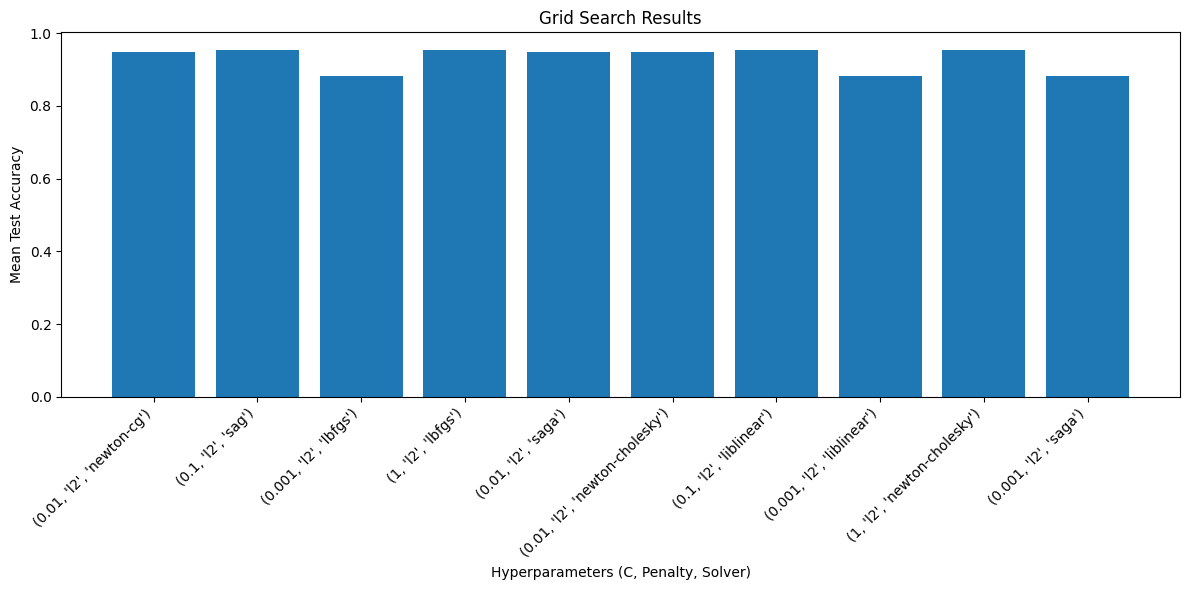

In [59]:
# Get the best hyperparameters
results = grid_logreg.cv_results_
param_combinations = list(zip(results['param_C'], results['param_penalty'], results['param_solver']))
scores = results['mean_test_score']

# Plot the accuracy scores for different hyperparameter combinations
plt.figure(figsize=(12, 6))
plt.bar(range(len(param_combinations)), scores)
plt.xticks(range(len(param_combinations)), param_combinations, rotation=45, ha="right")
plt.xlabel("Hyperparameters (C, Penalty, Solver)")
plt.ylabel("Mean Test Accuracy")
plt.title("Grid Search Results")
plt.tight_layout()
plt.show()

#### Print classification report and confusion matrix

In [60]:
print("Classification Report:\n", classification_report(y_test_sel, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sel, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      2864
           1       0.92      0.99      0.96      2743

    accuracy                           0.95      5607
   macro avg       0.96      0.96      0.95      5607
weighted avg       0.96      0.95      0.95      5607

Confusion Matrix:
 [[2642  222]
 [  32 2711]]


### Final XGBClassifier model:

##### Fitting and training the model

In [61]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the ensemble
    'max_depth': [3, 4, 5],  # Maximum depth of each tree
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for training each tree
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for training each tree
}

# Create GridSearchCV object
grid_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=5, scoring='accuracy')

# Fit the grid search
grid_xgb.fit(X_train_sel, y_train_sel)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='accuracy')

#### Obtaining best results and params

In [62]:
# Get the best hyperparameters
best_params = grid_xgb.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_xgb_model = grid_xgb.best_estimator_

# Evaluate the best model on the test data
y_pred = grid_xgb.predict(X_test_sel)
accuracy = accuracy_score(y_test_sel, y_pred)
print(f"Accuracy on Test Data: {accuracy}")

Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Accuracy on Test Data: 0.9564829677189228


#### Extracing the results

In [63]:
# Make predictions on the test data
y_pred = best_xgb_model.predict(X_test_sel)

# Calculate accuracy
accuracy = accuracy_score(y_test_sel, y_pred)
print(f"Accuracy on Test Data: {accuracy}")

Accuracy on Test Data: 0.9564829677189228


#### Ploting the results

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      2864
           1       0.92      0.99      0.96      2743

    accuracy                           0.96      5607
   macro avg       0.96      0.96      0.96      5607
weighted avg       0.96      0.96      0.96      5607



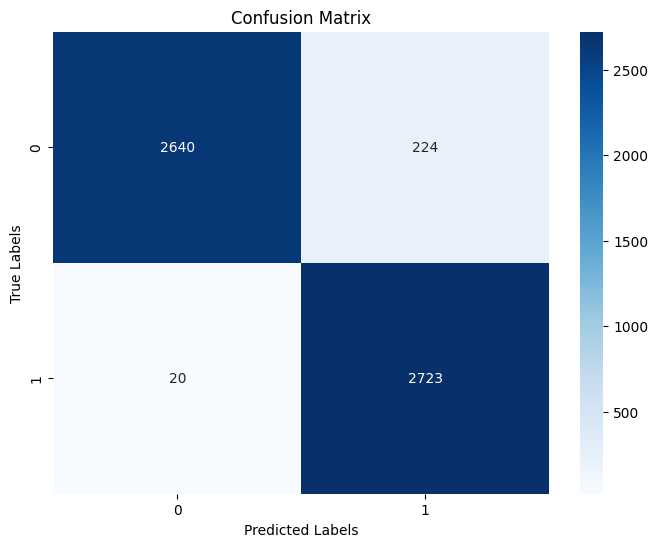

In [64]:
# Generate a classification report
report = classification_report(y_test_sel, y_pred)
print(report)

# Plot a confusion matrix
cm = confusion_matrix(y_test_sel, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Plotting the features importance:

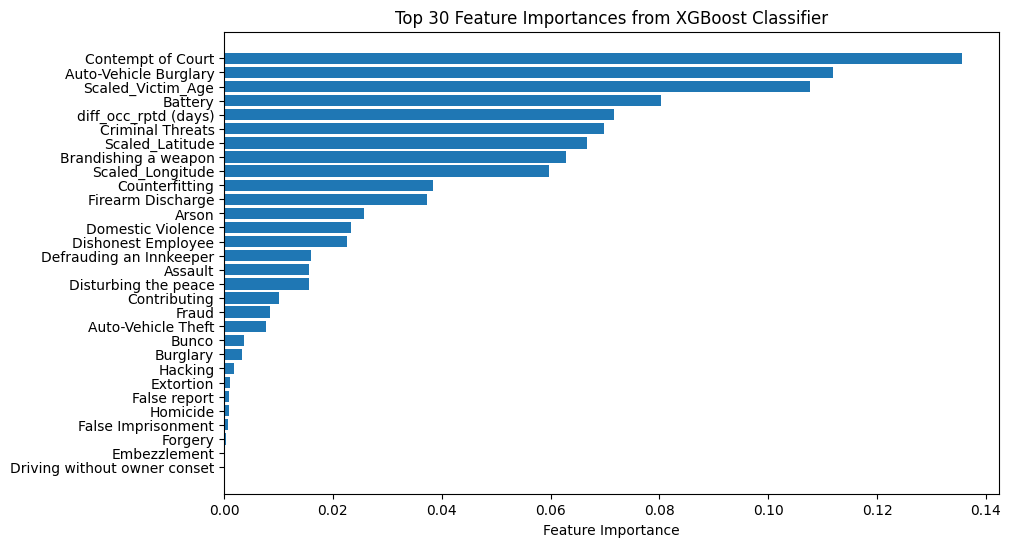

In [65]:
# Get feature importances from the model
feature_importance = best_xgb_model.feature_importances_

# Get the names of your feature columns
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot the top N most important features
top_n = 30  # Adjust to the number of features you want to plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), sorted_feature_importance[:top_n], align='center')
plt.yticks(np.arange(top_n), sorted_feature_names[:top_n])
plt.xlabel('Feature Importance')
plt.title('Top {} Feature Importances from XGBoost Classifier'.format(top_n))
plt.gca().invert_yaxis()
plt.show()

## Conclusion:

XGBClassifier performed better by having achievied higher accuracy score and lower type 1 and type 2 errors.